# JWST AMI Optical Simulations using dLuxWebbPSF

In this notebook I will work show the most basic example of how to use `dLuxWebbPSF` to simulate the AMI point spread function. The model presented here matches the model PSF generated by `WebbPSF` to within machine precision, including detector distortion effects. Additionally, it has the capability to generate Hexike aberrations over each individual mirror segment. And of course, all the code is differentiable, so we can use it for inference!

First, let's import relevant packages.

In [11]:
# jax
import jax.numpy as np
import jax.random as jr

# optical simulation
import webbpsf

# differentiable optical simulation
import dLux as dl
from dLux.utils import arcsec2rad as a2r, deg2rad as d2r
import dLuxWebbpsf as dlW

# visualisation
import matplotlib.pyplot as plt
plt.rcParams['image.origin'] = 'lower'

Alright, let's define the parameters of the simulation.

First, we will generate some random Hexike coefficients for each mirror segment; we will generate coefficients for the first three radial orders (i.e. piston, tip, tilt, defocus, astigmatism, coma).

We also define the flux of the point source and specify the filter used. We also can supply a date to load the WSS OPD map from.

In [12]:
# Hexike coefficients
def coeffs_shape(radial_orders, n_mirrors: int):
    return n_mirrors, int(np.sum(np.array(
        [dl.utils.triangular_number(i+1) - dl.utils.triangular_number(i) for i in radial_orders]
    )))

radial_orders = np.array([0, 1, 2], dtype=int)
hexike_coeffs = 1e-7 * jr.normal(jr.PRNGKey(0), coeffs_shape(radial_orders, 7))

# Flux of the image
flux = 1e6  # photons

# filter -- compatible with F380M, F430M, F480M
filter_name = "F480M"

# other model parameters
wss_date = "2023-02-01T00:00:00"  # Date time in ISO Format (YYYY-MM-DDThh:mm:ss) to load WSS OPD map
npix = 1024  # pixels
det_npix = 76  # pixels
oversample = 4

Here we generate the `WebbPSF` NIRISS optical system (e.g. transmission, OPD map), which we feed to `dLuxWebbpsf` to perform the differentiable simulation. We also grab the NIS_CEN aperture from the SIAF, which we will use to implement the detector distortion.

In [13]:
niriss = webbpsf.NIRISS()  # WebbPSF instrument
niriss.filter = filter_name
niriss.pupil_mask = "MASK_NRM" # applies the NRM mask -- remove this line for full pupil simulation
niriss.load_wss_opd_by_date(date=wss_date, verbose=False)  # loads the WSS OPD map for the given date
psfs = niriss.calc_psf()
niriss_osys = niriss.get_optical_system()

planes = niriss_osys.planes  # [Linear Model WSS, Coord inversion, FDA, NRM, Detector]
pscale = planes[-1].pixelscale.to("arcsec/pix").value  # arcsec/pix, grabbing pixel scale from detector plane

Finally, we build the `dLux`-based machinery for the simulation.

First, we build the `Optics` object, which represents the full optical system of NIRISS. This includes:
- the aberrated primary mirror
- a y-coordinate inversion
- the NRM mask
- a Fourier transform propagation to the image plane


We next build a `Source` object, which is a point source with a spectral flux distribution based on the F480M filter. 

We then build the `Detector` object, which implements the detector effects. This includes:
- a half-degree rotation to the detector frame
- the detector distortion based on the SIAF
- downsampling to the detector pixel scale
- (if we wanted to add telescope jitter, we would add it here)
- (if we wanted to model the Brighter-Fatter effect, we would add it here)

Finally, we collate the `Optics`, `Source`, and `Detector` objects into a `Telescope` object, which stores all this information in a single PyTree. I will create one instrument which is ignorant of detector effects, so we can see an oversampled PSF, and one instrument which includes detector effects, so we can see the final PSF.

In [14]:
# building the optical system for AMI
osys = dl.LayeredOpticalSystem(
    wf_npixels=1024,
    diameter=planes[0].pixelscale.to("m/pix").value * planes[0].npix,
    layers=[
        # (dlW.JWSTAberratedPrimary(
        ("Pupil", dlW.JWSTPrimary(
            transmission=planes[0].amplitude,  # transmission
            opd=planes[0].opd,  # WSS opd data
            pixelscale=pscale,  # pixel scale
            # radial_orders=radial_orders,
            # coefficients=hexike_coeffs,
            # AMI=True,  # FALSE FOR FULL PUPIL
        )),
        ("InvertY", dl.Flip(0)),
        ("Mask", dl.Optic(planes[-2].amplitude)),
        ("Propagator", dl.MFT(npixels=oversample * det_npix, pixel_scale=a2r(pscale)/oversample)),
    ]
)

# building a point source with the spectral flux distribution of the given filter
src = dl.PointSource(flux=flux, **dict(np.load(f"filter_configs/{filter_name}.npz")))

# building the detector, implementing rotation and distortion
detector = dl.LayeredDetector([
    dlW.detector_layers.Rotate(-d2r(getattr(niriss.siaf.apertures["NIS_CEN"], "V3IdlYAngle"))),
    dlW.DistortionFromSiaf(instrument=niriss, optics=niriss_osys),
    dl.Downsample(kernel_size=4),  # Downsample to detector pixel scale
])

# collating into dLux instrument
oversampled_telescope = dl.Telescope(optics=osys, source=src,  detector=None)
telescope = dl.Telescope(optics=osys, source=src, detector=detector)

To generate the PSF, we simply call the `.model()` method of the `Instrument` object. That's it!

In [15]:
oversampled_psf = oversampled_telescope.model()  # generating the oversampled PSF image
psf = telescope.model()  # generating the final PSF image

Let's have a look at our final PSF.

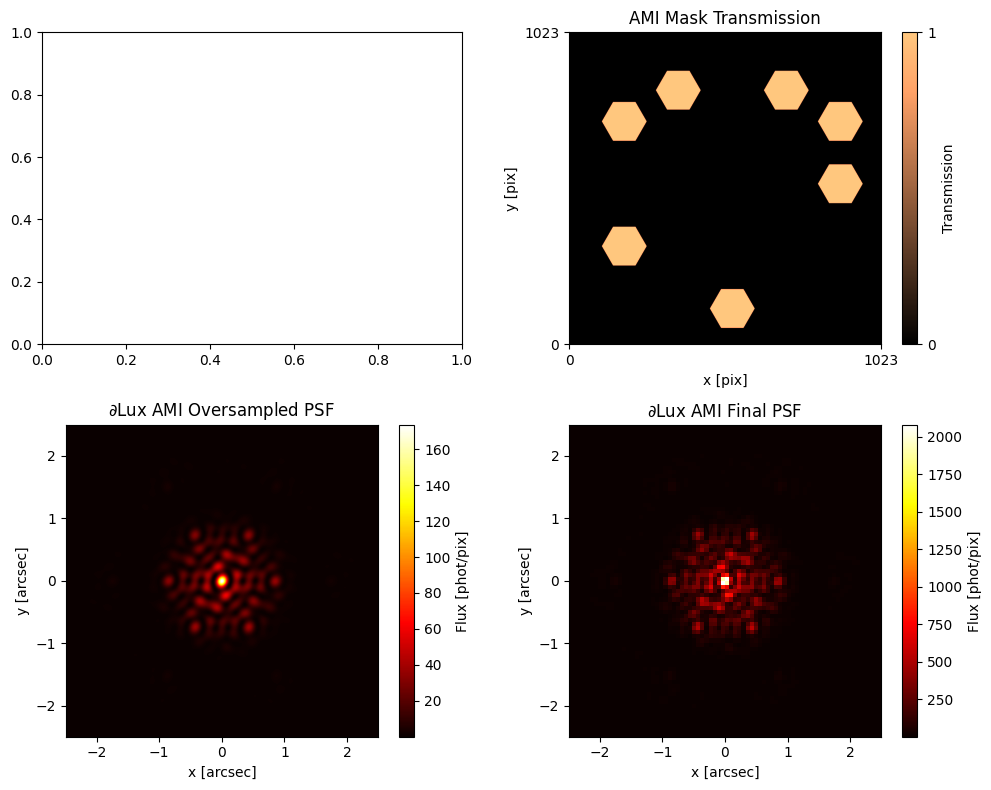

In [16]:
transmission = np.flip(planes[-2].amplitude, axis=0)  # NRM Transmission array, with y-axis flip
# total_opd = 1e6*(osys.Pupil.basis_opd + planes[0].opd)  # in microns
# t_mask = transmission.at[transmission < 1e-8]  # mask for cmaps
# ext = np.array([np.max(total_opd*t_mask.set(0)), np.abs(np.min(total_opd*t_mask.set(0)))]).max()  # cmap extent
ticks = [0, transmission.shape[0]-1]  # ticks for the pixel grids

# Plotting code
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2, figsize=(10.2, 8))
# # opd map
# ax0.imshow(total_opd, cmap='binary', vmin=-ext, vmax=ext)
# c0 = ax0.imshow(total_opd*t_mask.set(np.nan), cmap='seismic', vmin=-ext, vmax=ext)
# ax0.set(title="Total Primary OPD Map", xlabel="x [pix]", ylabel="y [pix]", xticks=ticks, yticks=ticks)
# fig.colorbar(c0, label='Optical Path Difference [$\mu$m]')

# transmission
c1 = ax1.imshow(transmission, cmap='copper')
ax1.set(title="AMI Mask Transmission", xlabel="x [pix]", ylabel="y [pix]", xticks=ticks, yticks=ticks)
fig.colorbar(c1, label="Transmission", ticks=[0, 1])

# oversampled point spread function
c2 = ax2.imshow(oversampled_psf, cmap='hot', extent=np.array([-1, 1, -1, 1]) * pscale * psf.shape[0] / 2,)
ax2.set(title="$\partial$Lux AMI Oversampled PSF", xlabel="x [arcsec]", ylabel="y [arcsec]")
fig.colorbar(c2, label='Flux [phot/pix]')

# point spread function at the detector
c3 = ax3.imshow(psf, cmap='hot', extent=np.array([-1, 1, -1, 1]) * pscale * psf.shape[0] / 2,)
ax3.set(title="$\partial$Lux AMI Final PSF", xlabel="x [arcsec]", ylabel="y [arcsec]")
fig.colorbar(c3, label='Flux [phot/pix]')

plt.tight_layout()
# plt.savefig("figures/5cells_img.pdf", dpi=300, bbox_inches='tight')
plt.show()

Let's compare our PSF directly with the `WebbPSF` simulated PSF.

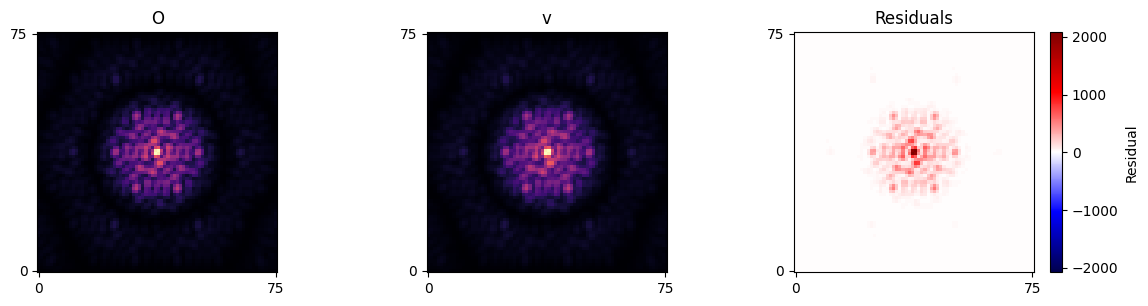

In [17]:
from utils import plot_and_compare

webbpsf_oversampled_psf = psfs[-2].data
webbpsf_detector_psf = psfs[-1].data

plot_and_compare(psf, webbpsf_detector_psf, "Oversampled PSF")


Contributors: Max Charles, Louis Desdoigts, Irina Troitskaya, Benjamin Pope, Peter Tuthill